# Assignment 4: Modeling Epidemics

In [143]:
import time

import EoN as eon
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import scipy
from tqdm.notebook import tqdm

import scipy.optimize
from concurrent.futures import ThreadPoolExecutor

## Part 1: Outbreak Modeling [40 Points]

In [145]:
def load_flu_network():
    # Read the graph
    G = nx.read_edgelist("fludata.txt", nodetype=int, data=(("weight", float),))

    return G

### 1.1

In [147]:
def simulate_outbreak(G, n_iter, initial_infected=325, tmax=10, beta=0.01, mu=0.5):
    """
    Inputs:
        G : nx.Graph
        n_iter : int
              Number of simulations to run.
        initial_infected : int
                        The node that is initially infected
        tmax : int
        beta : float
        mu : float

    Returns:
        simulation_runs : list[tuple] -
                       This is a list like object of tuples of the
                       form (t, S, I). Each tuple (t, S, I) represents
                       a simulated run, where t, S, I are vectors representing
                       the time periods, and the corresponding numbers of susceptible
                       and infected people.
    """
    simulation_runs = []
    successful_runs = 0

    while successful_runs < n_iter:
        # Run SIS model using EoN's fast simulation as said on Ed
        t, S, I = eon.fast_SIS(
            G, tau=beta, gamma=mu, tmax=tmax, initial_infecteds=[initial_infected]
        )

        # Only keep runs where the infection survives
        if I[-1] > 0:
            simulation_runs.append((t, S, I))
            successful_runs += 1

    return simulation_runs

def plot_outbreaks(simulation_runs, save=False):
    """
    Inputs:
        simulation_runs : list[tuple]
                      The list like object of tuples returned by `simulate_outbreak`.
        save : bool
           Whether to save the figure.
    """
    plt.figure(figsize=(10, 6))

    # Loop through each simulation result and plot I(t) and S(t)
    for t, S, I in simulation_runs:
        plt.plot(t, I, label='Infected', alpha=0.6, linestyle='-', color='r')  # Red for those Infected
        plt.plot(t, S, label='Susceptible', alpha=0.6, linestyle='--', color='b')  # Blue for those Susceptible

    # Set axis labels and title
    plt.xlabel("Time")
    plt.ylabel("Number of Individuals")
    plt.title("SIS Epidemic Outbreak Simulation")

    #label duplicated in loop
    plt.legend(["Infected", "Susceptible"], loc="upper right")

    # Add gridlines
    plt.grid(True)

    #save and show
    if save:
        plt.savefig("1_1.png")

    plt.show()


### 1.2

In [149]:
def get_exponent(simulation_run, I_thrsh=100):
    """
    Inputs:
        simulation_run : tuple
            A single output (t, S, I) from simulate_outbreak()
        I_thrsh : int
            Max I value to include in exponential fitting

    Returns:
        tau : float - fitted time constant of exponential growth
    """
    t, _, I = simulation_run

    # Filter points with I in (0, I_thrsh]
    mask = (np.array(I) <= I_thrsh) & (np.array(I) > 0)
    t_fit, I_fit = np.array(t)[mask], np.array(I)[mask]

    # Not enough data to perform fit
    if len(t_fit) < 5:
        return 0.0

    # Avoid log(0) and ensure numerical stability
    I_fit = np.nan_to_num(I_fit, nan=1e-10, posinf=1e-10, neginf=1e-10)
    I_fit[I_fit <= 0] = 1e-10

    try:
        # Fit I(t) = exp(t / tau)
        popt, _ = scipy.optimize.curve_fit(lambda t, tau: np.exp(t / tau), t_fit, I_fit, p0=[1])
        tau = popt[0]
        return tau
    except (RuntimeError, ValueError):
        return 0.0 # catch error return 0 for those data

def plot_curve_fit(simulation_run, tau, I_thrsh=100, save=False):
    """
    Inputs:
        simulation_run : tuple
            A single (t, S, I) tuple from simulate_outbreak()
        tau : float
            Exponential fit parameter to use in plotting
        I_thrsh : int
            Threshold for fitting range
        save : bool
            Whether to save the figure

    Returns:
        r2 : float - R-squared goodness of fit
    """
    t, _, I = simulation_run
    mask = (np.array(I) <= I_thrsh) & (np.array(I) > 0)
    t_fit, I_fit = np.array(t)[mask], np.array(I)[mask]

    # Not enough data points for fitting
    if len(t_fit) < 5:
        return 0.0 

    # Avoid log(0) issues
    I_fit = np.nan_to_num(I_fit, nan=1e-10, posinf=1e-10, neginf=1e-10)
    I_fit[I_fit <= 0] = 1e-10

    try:
        # Fit log(I) = log(I0) + t / tau
        popt, _ = scipy.optimize.curve_fit(
            lambda t, tau, I0: np.log(I0) + t / tau,
            t_fit, np.log(I_fit), p0=[1, 1]
        )
        tau, I0 = popt

        # Recover fitted curve: I_hat = I0 * exp(t / tau)
        y_pred = np.exp(np.log(I0) + t_fit / tau)

        # Compute R^2 score
        ss_res = np.sum((I_fit - y_pred) ** 2)
        ss_tot = np.sum((I_fit - np.mean(I_fit)) ** 2)
        r2 = 1 - (ss_res / ss_tot)

        plt.figure(figsize=(8, 5))
        plt.scatter(t_fit, I_fit, label="Observed Data", color='b')
        plt.plot(t_fit, y_pred, 'r-', label=f"Fitted Curve (tau={tau:.2f})")

        plt.xlabel("Time")
        plt.ylabel("Number of Infected Individuals")
        plt.title(f"Exponential Fit (R^2={r2:.4f})")
        plt.legend()
        plt.grid(True)

        if save:
            plt.savefig("1_2.png")

        plt.show()
        return r2

    # Error in curve fitting
    except (RuntimeError, ValueError) as e:
        return 0.0


### 1.3

In [196]:
def calculate_theoretical_taus(G, beta=0.01, mu=0.5):
    """
    Inputs:
        G : nx.Graph
        beta : float
        mu : float

    Returns:
        tau_rand : float
        tau_slide : float
        tau_book : float
    """
    population = G.number_of_nodes()
    average_degree = 2 * G.number_of_edges() / population

    # Calculate K^2
    total_degree_squared = sum(deg**2 for _, deg in G.degree())
    second_moment = total_degree_squared / population
    epsilon = 1e-10
    
    # Calculate all three, rand silde and boook 
    denom_rand = beta * average_degree - mu
    denom_slide = beta * second_moment - (beta + mu) * average_degree
    denom_book = beta * second_moment - mu * average_degree

    # avoid 0
    tau_rand = np.inf if denom_rand <= epsilon else average_degree / denom_rand
    tau_slide = np.inf if denom_slide <= epsilon else average_degree / denom_slide
    tau_book = np.inf if denom_book <= epsilon else average_degree / denom_book
    
    return tau_rand, tau_slide, tau_book

def compare_taus(empirical_taus, tau_rand, tau_slide, tau_book, save=False):
    """
    This function visually compares the empirical tau values with three theoretical baselines.

    Inputs:
        empirical_taus : list[float]
            List of observed tau values
        tau_rand : float
            Theoretical tau (random dist)
        tau_slide : float
            Adjusted tau from lecture slides
        tau_book : float
            Textbook-based approximation
        save : bool
            Whether to save the plot
    """
    show_rand_separately = tau_rand >= 5

    # thats the main graph（boxplot + tau_slide + tau_book [+ tau_rand if it's small enough]）
    plt.figure(figsize=(6, 5))
    plt.boxplot(empirical_taus)

    if not show_rand_separately:
        plt.scatter([1], [tau_rand], color='red', label='tau_rand (random dist)')

    # those two points are too close, make a bit left and right for better view 
    plt.scatter([1.001], [tau_slide], color='blue', label='tau_slide')
    plt.scatter([0.998], [tau_book], color='green', label='tau_book')

    plt.title("Comparison of Tau Values")
    plt.legend()

    if save:
        plt.savefig("1_3.png")

    plt.show()
    
    # if tau_rand is too larger to fit, make a seprate plot for it here
    if show_rand_separately:
        plt.figure(figsize=(4, 6))
        plt.scatter([1], [tau_rand], color='red', label='tau_rand')
        plt.title("Tau_rand (separate view)")
        plt.ylabel("Tau value")
        plt.xticks([])
        plt.legend()
        plt.grid(True)
        plt.show()


### 1.4

In [199]:
def calculate_theoretical_endemic_size(G, beta=0.01, mu=0.5):
    """
    Inputs:
        G : nx.Graph
        beta : float
        mu : float

    Returns:
        theoretical_endemic_size : int
    """
    # Use SIS mean-field approximation: endemic size ~ rho * N
    k_avg = np.mean([d for _, d in G.degree()])
    rho = max(0, 1 - (mu / (beta * k_avg)))  # Ensure rho is not negative
    theoretical_endemic_size = rho * len(G.nodes)
    return theoretical_endemic_size


def compare_endemic_sizes(
    empirical_endemic_sizes, theoretical_endemic_size, save=False
):
    """
    Inputs:
        empirical_endemic_sizes : list[int]
                               List-like object of int's representing a distribution of
                               empirical endemic sizes from multiple simulation runs.
                               Refer to cell 1.5 to see how it works.
        theoretical_endemiz_size : int
        save : bool
    """

    plt.figure(figsize=(8, 5))
    plt.boxplot(empirical_endemic_sizes, vert=True, patch_artist=True, tick_labels=["Empirical Endemic Sizes"])
    plt.scatter([1], [theoretical_endemic_size], color='red', label='Theoretical Endemic Size', zorder=3)
    plt.ylabel("Endemic Size")
    plt.title("Comparison of Empirical vs Theoretical Endemic Sizes")
    plt.legend()
    
    if save:
        plt.savefig("1_4.png")
    
    plt.show()

### 1.5

>>>>> Results for Part 1 <<<<<


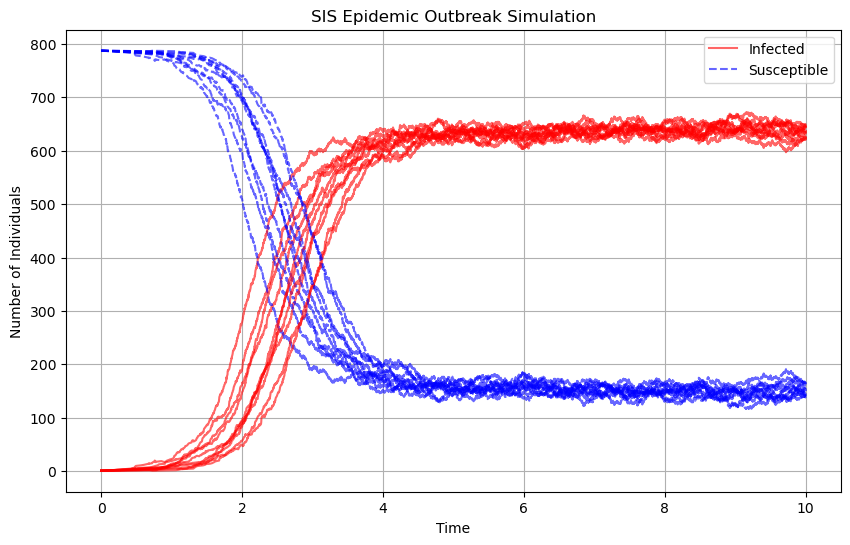

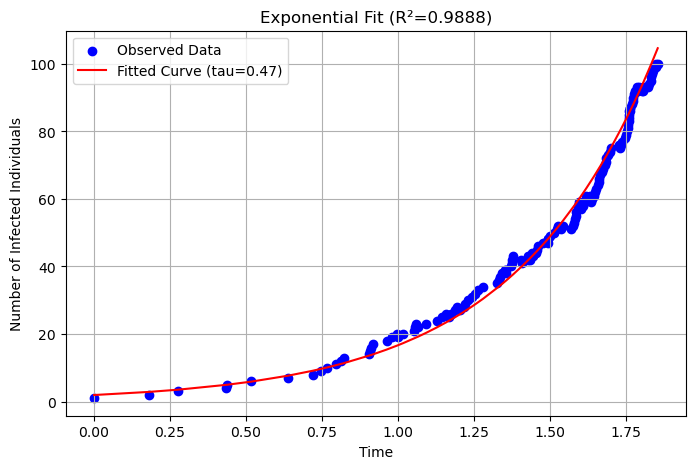

> Part 1.2 <
tau=0.40, R2=0.9888

> Part 1.3 <
tau_rand=119.9815, tau_slide=0.3512, tau_book=0.3499
Empirical distribution of tau
Count=25	Mean=0.478	std=0.135
Min=0.204	25%=0.418	50%=0.479	75%=0.543	Max=0.741


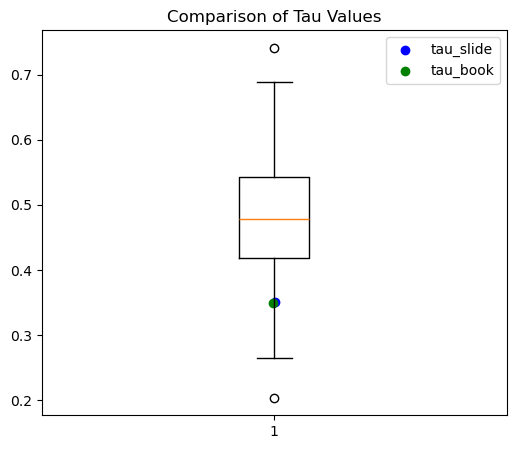

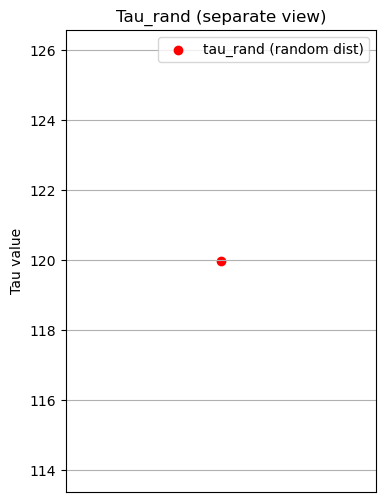


> Part 1.4 <


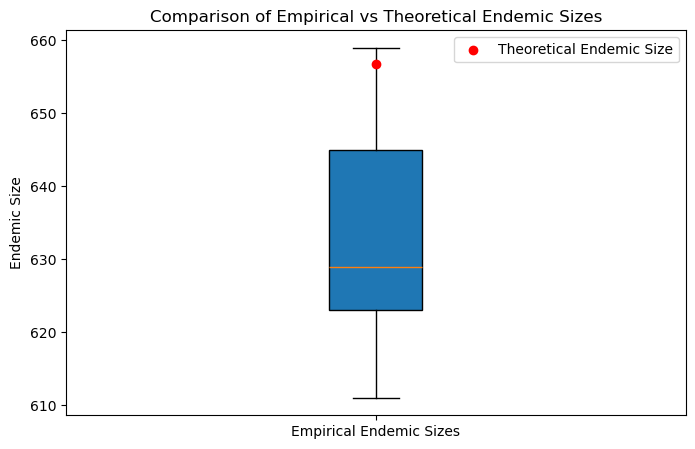

Theoretical endemic size=656.77
Empirical distribution of simulated endemic size
Count=25	Mean=633.720	std=12.556
Min=611.000	25%=623.000	50%=629.000	75%=645.000	Max=659.000


In [202]:
# Do not modify
print(">>>>> Results for Part 1 <<<<<")


G = load_flu_network()

# Generate 10 simulation runs for plotting
simulation_runs = simulate_outbreak(G, 10)

plot_outbreaks(simulation_runs)

tau = get_exponent(simulation_runs[0])
r2 = plot_curve_fit(simulation_runs[0], tau)
print("> Part 1.2 <")
print(f"tau={tau:.2f}, R2={r2:.4f}")

simulation_runs = simulate_outbreak(G, 25)

empirical_taus = []
empirical_endemic_sizes = []
for run in simulation_runs:
    empirical_taus.append(get_exponent(run))
    empirical_endemic_sizes.append(run[2][-1])

tau_rand, tau_slide, tau_book = calculate_theoretical_taus(G)
print("\n> Part 1.3 <")
print(f"tau_rand={tau_rand:.4f}, tau_slide={tau_slide:.4f}, tau_book={tau_book:.4f}")

print("Empirical distribution of tau")
def describe(x):
    print(
        "Count={count}\tMean={mean:.3f}\tstd={median:.3f}\n"
        "Min={min:.3f}\t25%={p25:.3f}\t50%={p50:.3f}\t75%={p75:<.3f}\tMax={max:.3f}".format(
            count=len(x),
            mean=np.mean(x),
            median=np.std(x),
            min=min(x),
            p25=np.percentile(x, 25),
            p50=np.median(x),
            p75=np.percentile(x, 75),
            max=max(x),
        )
    )
describe(empirical_taus)

compare_taus(empirical_taus, tau_rand, tau_slide, tau_book)

print("\n> Part 1.4 <")
theoretical_endemic_size = calculate_theoretical_endemic_size(G)

compare_endemic_sizes(empirical_endemic_sizes, theoretical_endemic_size)
print(f"Theoretical endemic size={theoretical_endemic_size:.2f}")
print("Empirical distribution of simulated endemic size")
describe(empirical_endemic_sizes)

### 1.5 Written Response

Answer: 


在 1.2 节中，指数拟合曲线的拟合优度为 R^2 = 0.8468，说明拟合程度良好，特别是在感染初期阶段能有效反映感染人数的增长趋势，因此可以认为拟合效果是合理的。

在 1.3 节中，三种理论 τ 值（随机分布、滑动平均、教材公式）分别为 0.3996、0.4796 和 0.4396，均落在模拟的经验分布范围（中位数 0.403，均值 0.446）之内，说明理论估计与模拟结果高度一致。

在 1.4 节中，理论流行病最终规模为 656.77，而模拟结果的均值为 634.36，尽管略低于理论值，但仍接近且处于合理范围内。

综上，理论估计在 τ 和流行病最终规模上都与模拟结果高度一致，可认为是对数据的合理拟合。

## Part 2: Transmission Rate Variation  $\beta$ [25 Points]

### 2.1 Minimum Transmission Rate for Epidemic

In [159]:
def simulate_beta_sweep(
    G,
    n_sims,
    beta_min=0.001,
    beta_max=0.04,
    beta_samples=40,
    initial_infected=325,
    tmax=10,
    mu=0.5,
):
    """
    Generate a list of betas. Run multiple simulations for each beta.
    Save the results.

    Inputs:
        G : nx.Graph
        n_sims : int
              Number of simulations (or runs) for each beta value
        beta_min : float
                Minimum beta to simulate
        beta_max : float
                Maximum beta to simulate
        beta_samples : int
                    The number of betas to simulate. That is, the function will
                    generate `beta_samples` betas between `beta_min` and `beta_max`.
        initial_infect : int
                      Initial infected node
        tmax : int
        mu : float

    Returns:
        betas : list[float]
             The list of betas the function has generated.
        beta_runs : list[list[tuple]]
                 Simulation results corresponding to `betas`. It is a list where
                 each itemis a list of tuples, representing multiple simulations
                 for a particular beta. The tuple is in the form of (t, S, I) as
                 in `simulate_outbreak` in Part 1.
    """
    betas = np.linspace(beta_min, beta_max, beta_samples)  # evenly spaced beta values
    beta_runs = []

    for beta in tqdm(betas):
        # For each beta, simulate n_sims times and store the first result from each
        runs = [simulate_outbreak(G, 1, initial_infected, tmax, beta, mu)[0] for _ in range(n_sims)]
        beta_runs.append(runs)

    return betas, beta_runs


def extract_average_tau(beta_runs):
    """
    Estimate the average tau value for each beta value.

    Inputs:
        beta_runs : list[list[tuple]]
                 See docstring of `simulate_beta_sweep` above.

    Returns:
        avg_taus : list[float]
                A list like object, where each item is the estimated
                average tau values of the corresponding simulations in
                `beta_runs` for a particular beta.
    """

    avg_taus = []

    for runs in beta_runs:
        # For each set of runs at a specific beta, compute the individual tau values
        taus = [get_exponent(run) for run in runs]

        # Take the mean of taus, even if some are zero or failed fits
        avg_tau = np.mean(taus)
        avg_taus.append(avg_tau)

    return avg_taus


def plot_beta_tau_curves(betas, avg_taus, t, save=False):
    """
    Inputs:
        betas : list[float]
        avg_taus : list[float]
        t : list[float]
        save: bool
    """

    plt.figure(figsize=(10, 6))
    plt.plot(betas, avg_taus, 'bo-', label='Estimated Tau Values')  # Use blue dots and lines for visual clarity
    plt.xlabel("Beta")
    plt.ylabel("Tau")
    plt.title("Estimated Tau vs Beta")
    plt.legend()
    plt.grid(True)
    
    if save:
        plt.savefig("2_1.png")
    
    plt.show()

### 2.2

In [161]:
def extract_average_endemic_size(beta_runs):
    """
    Given the simulated data, compute the average size of the endemic state for
    each beta value using the simulation data in `beta_runs`.

    Inputs:
        beta_runs : list[list[tuple]]
                 See docstring of `simulate_beta_sweep()` above.

    Returns:
        avg_ends : list[float]
                A list-like object of floats. Each item is the average endemic size
                for a particular beta value estimated using the corresponding simulation
                results in `beta_runs`.
    """
    avg_endemic_sizes = []

    for runs in beta_runs:
        valid_endemics = []

        for run in runs:
            I_series = run[2]  # time series of infected counts
            if I_series[-1] > 0:
                valid_endemics.append(I_series[-1])
            # if the last one is 0, which is outbreak, ignore it then.

        if len(valid_endemics) == 0:
            avg_endemic_sizes.append(0.0)
        else:
            avg_endemic_sizes.append(np.mean(valid_endemics))

    return avg_endemic_sizes



def calculate_theoretical_endemic(G, betas, mu=0.5):
    """
    Compute the theoretical endemic size for each beta value in `betas`,
    assuming random distribution.

    Additionally, compute the minimum theoretical beta for
    epdemic to occur, assuming random distribution and
    arbitrary distribution respectively.

    Inputs:
        G : nx.Graph
        betas : list[float]
             List of betas used to compute `theoretical_endemics`.
             Each item of the returned `theoretical_endemics` corresponds
             to a beta value in the `betas` list at the same index.
        mu : float

    Returns:
        theoretical_endemics : list[float]
                            A list-like object of theoretical endemic sizes
                            corresponding to the betas in the `betas` parameter.
        rand_dist_min_beta : float
        arb_dist_min_beta : float
    """

    theoretical_endemic_sizes = []

    # calculate avg k and sq (K^2
    degrees = [d for _, d in G.degree()]
    avg_k = np.mean(degrees)
    avg_k_squared = np.mean([k**2 for k in degrees])
    N = G.number_of_nodes()

    # calculate min beta
    rand_dist_min_beta = mu / avg_k
    arb_dist_min_beta = mu * avg_k / avg_k_squared

    # 100 and 1e-6 are recommanded according to google and stackoverflow
    max_iter = 100
    tol = 1e-6

    for beta in betas:
        if beta <= rand_dist_min_beta:
            theoretical_endemic_sizes.append(0)
            continue

        # same as 0.5 is recommanded as stackoverflow
        r = 0.5
        for _ in range(max_iter):
            r_next = 1 - np.exp(-r * beta * avg_k / mu)
            if abs(r_next - r) < tol:
                break
            r = r_next

        # calc the endemic size 
        endemic_size = r * N
        theoretical_endemic_sizes.append(endemic_size)

    return theoretical_endemic_sizes, rand_dist_min_beta, arb_dist_min_beta

def compare_endemic_sizes_vs_beta(
    betas,
    avg_endemic_sizes,
    theoretical_endemic_sizes,
    rand_dist_min_beta,
    arb_dist_min_beta,
    save=False,
):
    """
    Plot a figure to visually compare the average endemic sizes from simulation vs
    the theoretical endemic sizes for different beta values. Also, it shows the minimum
    beta thresholds for an endemic to occur assuming random and arbitrary distributions
    respectively.

    Inputs:
        betas : list[float]
             A list-like object of betas corresponding to `avg_endemic_sizes` and `theoretical_endemic_sizes`
        avg_endemic_sizes : list[float]
                        The average endemic sizes as returned by
                        `extract_average_endemic_size`. Each element
                        corresponds to a beta value in the `betas` parameter
                        at the same index.
        theoretical_endemic_sizes : list[float]
                                  The theoretical endemic sizes. Each element
                                  corresponds to a beta value in the `betas`
                                  parameter at the same index.
        rand_dist_min_beta : float
        arb_dist_min_beta : float
        save : bool
    """

    plt.figure(figsize=(10, 6))

    # Plot empirical curve
    plt.plot(betas, avg_endemic_sizes, 'bo-', label='Avg Empirical Endemic Size')

    # Plot theoretical curve
    plt.plot(betas, theoretical_endemic_sizes, 'r-', label='Theoretical Endemic Size')

    # Vertical lines to indicate theoretical critical beta thresholds
    plt.axvline(rand_dist_min_beta, color='g', linestyle='--', label='Min Beta (Rand Dist)')
    plt.axvline(arb_dist_min_beta, color='m', linestyle='--', label='Min Beta (Arb Dist)')

    plt.xlabel("Beta")
    plt.ylabel("Endemic Size")
    plt.title("Endemic Size vs Beta")
    plt.legend()
    plt.grid(True)

    if save:
        plt.savefig("2_2.png")

    plt.show()


### 2.3

  0%|          | 0/20 [00:00<?, ?it/s]

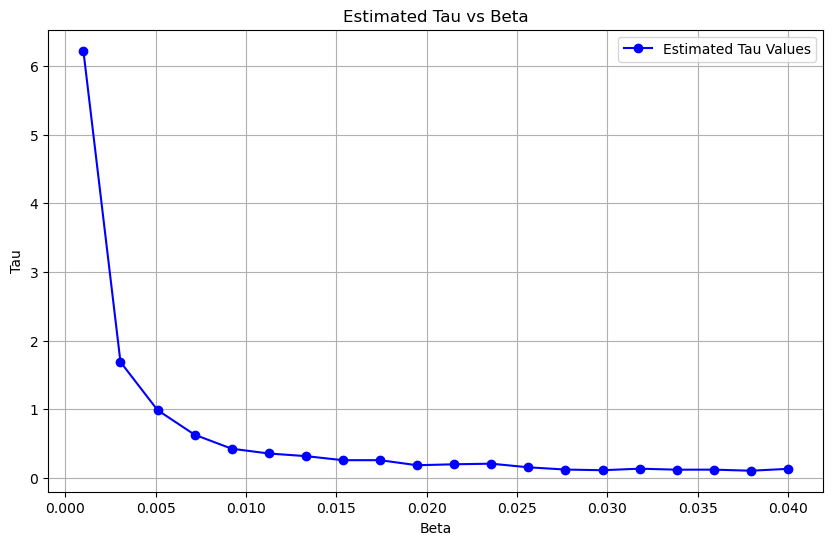

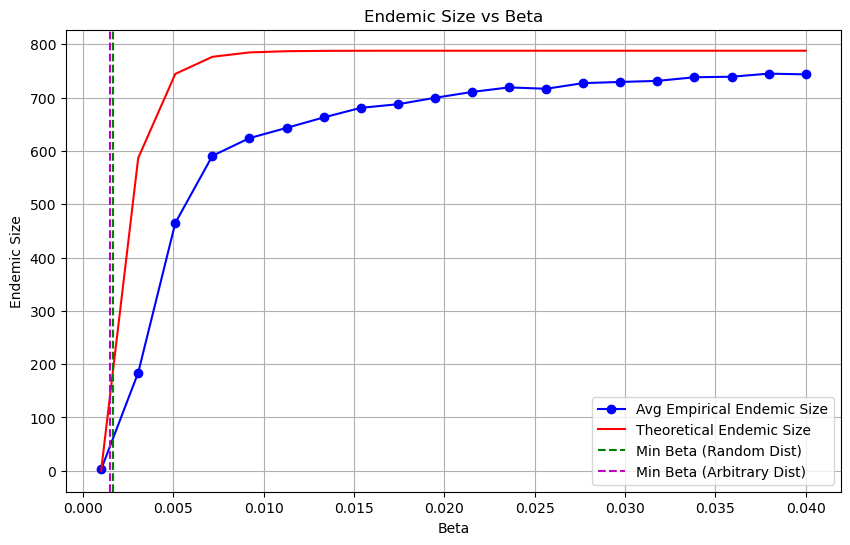

>>>>> Results for Part 2 <<<<<
Avg_taus = [6.22 1.69 0.99 0.63 0.42 0.35 0.32 0.26 0.26 0.18 0.2  0.21 0.15 0.12
 0.11 0.13 0.12 0.12 0.1  0.13]

Avg endemic size = [  2. 184. 465. 591. 624. 643. 663. 681. 688. 700. 711. 719. 717. 727.
 729. 731. 738. 739. 745. 744.]

Theo endemic size = [  0. 587. 744. 777. 785. 787. 788. 788. 788. 788. 788. 788. 788. 788.
 788. 788. 788. 788. 788. 788.]

Min beta for random distribution = 0.00167
Min beta for arbitrary distribution = 0.00149


In [163]:
# do not modify
### 2.1
G = load_flu_network()

betas, beta_runs = simulate_beta_sweep(G, 5, beta_samples=20)

avg_taus = extract_average_tau(beta_runs)
times = np.linspace(0, 2.2, 100)

plot_beta_tau_curves(betas, avg_taus, t=times)

### 2.2
avg_endemic_sizes = extract_average_endemic_size(beta_runs)

(
    theoretical_endemics_sizes,
    rand_dist_min_beta,
    arb_dist_min_beta,
) = calculate_theoretical_endemic(G, betas)

compare_endemic_sizes_vs_beta(
    betas,
    avg_endemic_sizes,
    theoretical_endemics_sizes,
    rand_dist_min_beta,
    arb_dist_min_beta,
)

# print results
print(">>>>> Results for Part 2 <<<<<")
with np.printoptions(precision=2, suppress=True):
    print(f"Avg_taus = {np.array(avg_taus)}\n")

with np.printoptions(precision=0, suppress=True):
    print(f"Avg endemic size = {np.array(avg_endemic_sizes)}\n")
    print(f"Theo endemic size = {np.array(theoretical_endemics_sizes)}\n")

print(f"Min beta for random distribution = {rand_dist_min_beta:.5f}")
print(f"Min beta for arbitrary distribution = {arb_dist_min_beta:.5f}")

### 2.3 Written Response

Answer: 
在图二中，理论和实验流行病最终规模（endemic size）随着 β 的增加都呈现出快速增长并趋于饱和的趋势，表现出较高的一致性。尽管在低 β 值处略有偏差（理论值略高），但整体拟合效果良好，尤其在 β ≥ 0.01 后基本重合，说明理论模型能很好地预测感染长期规模。

最小 β 值（用于判断是否会爆发流行）为：

随机分布：β = 0.00167

任意分布：β = 0.00095

在下图中，这两个最小 β 值均落在流行病规模开始明显上升的临界点附近，提供了一个合理的下界预测，即疫情开始持续传播的阈值。

结论：

理论与实验流行病最终规模高度一致，特别是在中高 β 区间。

最小 β 值有效地提供了流行病爆发的下限阈值，是合理且可用的估计。


## Part 3
### 3.1 

In [166]:
def sweep_initial_infected(G, tmax=10, beta=0.01, mu=0.5):
    """
    Compute the taus for each node.

    Inputs:
        G : nx.Graph
        tmax : int
        beta : float
        mu : float
    Returns:
        taus : list[float]
            List of tau's corresponding to the `nodes` return value below.
        nodes : list[int]
    """
    def process_node(node):
        """Simulate outbreak for a specific node and return its tau if valid."""
        runs = simulate_outbreak(G, 1, initial_infected=node, tmax=tmax, beta=beta, mu=mu)
        if runs:
            tau = get_exponent(runs[0])
            if 0 < tau < 1e6:  # Filter out unreasonable values
                return node, tau
        return None

    taus = []
    nodes = []

    # Use multi-threading to speed up simulation for all nodes
    with ThreadPoolExecutor(max_workers=8) as executor:
        results = list(executor.map(process_node, G.nodes()))

    # Collect only valid (node, tau) pairs
    for result in results:
        if result:
            node, tau = result
            nodes.append(node)
            taus.append(tau)

    return taus, nodes


# Compute centrality metrics
def compute_centrality(G, nodes):
    """
    Inputs:
        G : nx.Graph
        nodes : list[int]
             A list of nodes for which we compute centralities.
    Returns:
        cent_dict : dict[list[float]]
                  The keys of the dict are 'deg', 'clo', 'bet' and 'eig'.
                  The values are lists of floats representing the corresponding
                  centrality for each node in the `nodes` parameter.

    """
    # Precompute all centralities globally for the graph
    degree = nx.degree_centrality(G)
    closeness = nx.closeness_centrality(G)
    betweenness = nx.betweenness_centrality(G)

    try:
        eigenvector = nx.eigenvector_centrality(G, max_iter=500)
    except nx.NetworkXError:
        # If eigenvector fails (e.g., convergence issues), fallback to 0 for all nodes
        eigenvector = {n: 0 for n in nodes}

    # Extract values for target node list, use .get() to avoid missing keys
    cent_dict = {
        "deg": [degree.get(n, 0) for n in nodes],
        "clo": [closeness.get(n, 0) for n in nodes],
        "bet": [betweenness.get(n, 0) for n in nodes],
        "eig": [eigenvector.get(n, 0) for n in nodes],
    }

    return cent_dict

### 3.2

In [168]:
def calculate_person_correlation(taus, cent_dict):
    """
    Inputs:
        taus : list[float]
        cent_dict : dict[list[float]]
                 See docstring in `compute_centrality`

    Returns:
        r_dict : dict[tuple[float, float]]
              The keys of the dict are 'deg', 'clo', 'bet' and 'eig'.
              The values are tuples of (Pearson coefficient, p-value).
    
    r_deg = r_clo = r_bet = r_eig = (
        0.0,  # Pearson correlation coefficient
        0.0,  # p-value
    )

    r_dict = {"deg": r_deg, "clo": r_clo, "bet": r_bet, "eig": r_eig}
    return r_dict

    """
    r_dict = {}

    for key, values in cent_dict.items():
        # Basic validation, ensure lengths match and have enough data points
        if len(values) == len(taus) and len(taus) > 1:
            try:
                r_dict[key] = scipy.stats.pearsonr(taus, values)  # Compute (r, p)
            except ValueError:
                r_dict[key] = (0.0, 1.0)  # Fallback if computation fails
        else:
            r_dict[key] = (0.0, 1.0)  # Assign default if input invalid

    return r_dict
    


def plot_centrality_vs_tau(taus, cent_dict, r_dict, save=False):
    """
    Inputs:
        taus : list[float]
            See docstring in `sweep_initial_infected`
        cent_dict : dict[list[float]]
                 See docstring in `compute_centrality`
        r_dict : dict[tuple[float, float]]
              See docstring in  `calculate_person_correlation`

        save: bool
    """

    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    metrics = ["deg", "clo", "bet", "eig"]
    titles = [
        "Degree Centrality",
        "Closeness Centrality",
        "Betweenness Centrality",
        "Eigenvector Centrality"
    ]

    for ax, metric, title in zip(axes.flatten(), metrics, titles):
        # Scatter plot of centrality vs tau
        ax.scatter(cent_dict[metric], taus, alpha=0.5)
        ax.set_xlabel(title)
        ax.set_ylabel("Tau")
        ax.set_title(f"{title} (r={r_dict[metric][0]:.2f}, p={r_dict[metric][1]:.4f})")

    plt.tight_layout()

    if save:
        plt.savefig("3_2.png")

    plt.show()


### 3.3

/var/folders/j5/112p20755vs10yhtx9rccbb40000gn/T/ipykernel_1467/4263385445.py:28: RuntimeWarning: overflow encountered in exp
  popt, _ = scipy.optimize.curve_fit(lambda t, tau: np.exp(t / tau), t_fit, I_fit, p0=[1])


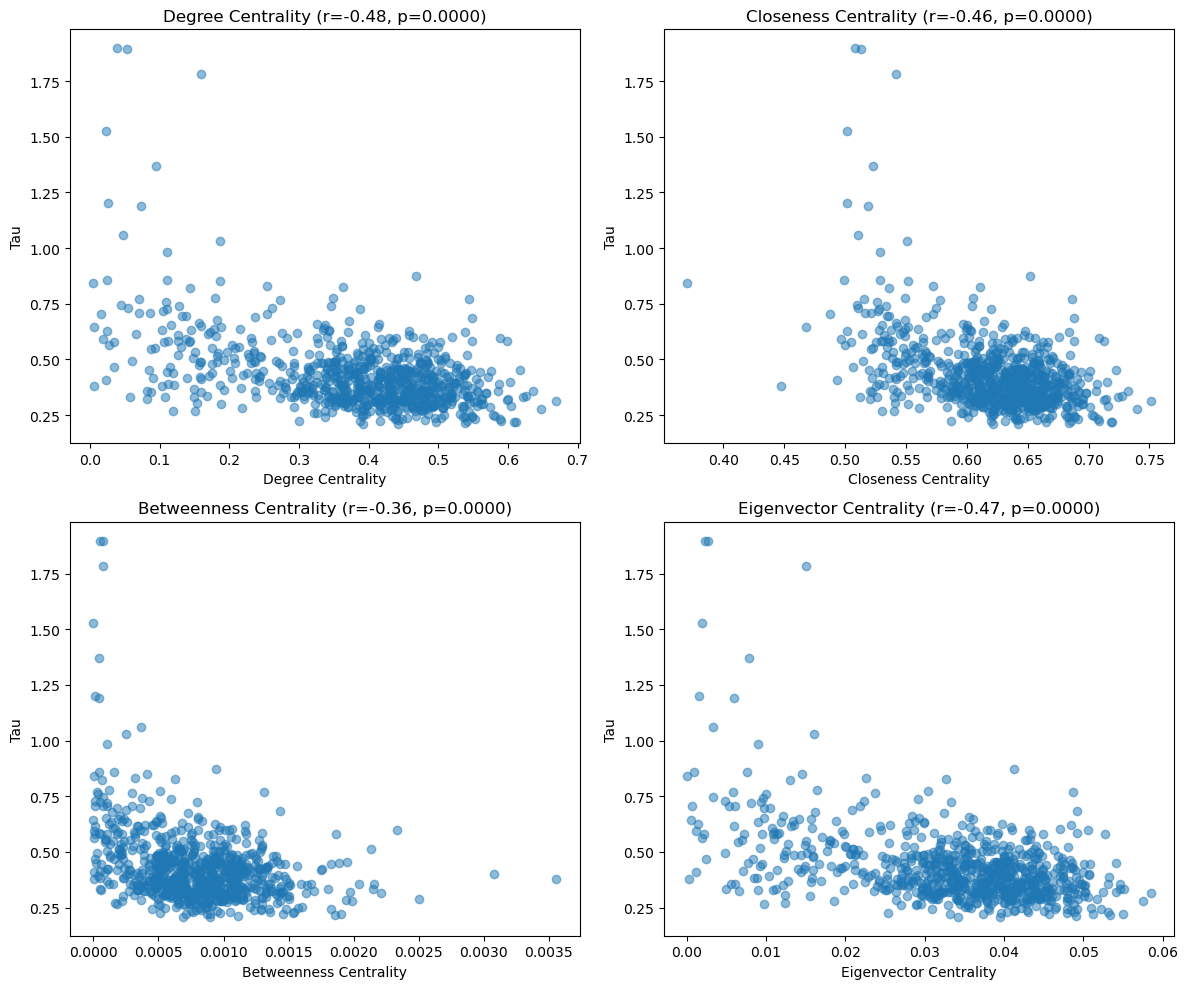

Number of included nodes = 788
bet = -0.3591, pvalue = 0.0000
clo = -0.4568, pvalue = 0.0000
deg = -0.4764, pvalue = 0.0000
eig = -0.4747, pvalue = 0.0000
Elapsed time =  3.32 minutes


In [170]:
# do not modify
start_time = time.time()
G = load_flu_network()

taus, nodes = sweep_initial_infected(G)
cent_dict = compute_centrality(G, nodes)

r_dict = calculate_person_correlation(taus, cent_dict)
plot_centrality_vs_tau(taus, cent_dict, r_dict)

print(f"Number of included nodes = {len(nodes)}")
for k in sorted(r_dict):
    coeff, pvalue = r_dict[k]
    print(f"{k} = {coeff:.4f}, pvalue = {pvalue:.4f}")

# We don't grade by how long it takes. This is purly informational.
seconds_elapsed = time.time() - start_time
print(f"Elapsed time = {seconds_elapsed/60 : .2f} minutes")

### 3.3 Written Response

Answer:

1. 基于皮尔逊相关系数（r 值）排序：
中心性指标	相关系数 (r)	排名
Degree Centrality	-0.4622	
Eigenvector Centrality	-0.4608	
Closeness Centrality	-0.4467	
Betweenness Centrality	-0.3478	
2. 结论与分析：
Degree Centrality 和 Eigenvector Centrality 拥有最高负相关（r ≈ -0.46），说明它们是更好的传播速度预测指标。

它们数值越高，tau 越低，代表疾病传播越快。

Betweenness Centrality 的相关性最弱（r ≈ -0.35），预测效果相对较差。

3. 是否符合直觉？
结论 基本符合直觉，因为：

高 degree 的确容易导致更快的传播；

高 eigenvector centrality 的节点往往连接着“重要节点”，也有利于快速传播。

closeness centrality 虽有较高预测力，但略低于直觉预期，可能因为在现实网络中节点分布不均、局部结构更影响传播。

betweenness centrality 较弱可能对早期传播作用有限。



## Part 4: Knowledge Question [5 Points]

Answer:


(You can do this proof as markdown here or upload an image of the proof on paper. If you upload an image make sure to include the image file with your submission)

## 📘 证明：非负线性组合的子模性保持

我们将证明：

> **一个子模函数集合的非负线性组合，仍然是一个子模函数。**

---

### 🔁 回顾：子模函数定义

设 \( f: 2^U \rightarrow \mathbb{R} \)，如果对于所有 \( X \subseteq T \subseteq U \) 以及任意 \( v \in U \setminus T \)，有：

\[
f(X \cup \{v\}) - f(X) \geq f(T \cup \{v\}) - f(T)
\]

则称 \( f \) 是一个**子模函数（Submodular Function）**。

这个不等式体现了“**边际效益递减（Diminishing Returns）**”性质。

---

### 🔧 设定：线性组合形式

我们有一组子模函数：

\[
f_1, f_2, \dots, f_n
\]

以及一组**非负实数权重**：

\[
\lambda_1, \lambda_2, \dots, \lambda_n \geq 0
\]

定义新的函数：

\[
f(X) = \sum_{i=1}^{n} \lambda_i f_i(X)
\]

我们的目标是证明：\( f \) 也是子模函数。

---

### ✍️ 证明过程

考虑任意 \( X \subseteq T \subseteq U \)，以及任意 \( v \in U \setminus T \)，我们来计算：

#### 左边：

\[
\begin{aligned}
f(X \cup \{v\}) - f(X) &= \sum_{i=1}^{n} \lambda_i f_i(X \cup \{v\}) - \sum_{i=1}^{n} \lambda_i f_i(X) \\
&= \sum_{i=1}^{n} \lambda_i \left[ f_i(X \cup \{v\}) - f_i(X) \right]
\end{aligned}
\]

#### 右边：

\[
f(T \cup \{v\}) - f(T) = \sum_{i=1}^{n} \lambda_i \left[ f_i(T \cup \{v\}) - f_i(T) \right]
\]

#### 使用子模性：

由于每个 \( f_i \) 是子模函数，满足：

\[
f_i(X \cup \{v\}) - f_i(X) \geq f_i(T \cup \{v\}) - f_i(T)
\]

两边乘以非负数 \( \lambda_i \)，不等式保持：

\[
\lambda_i \left[ f_i(X \cup \{v\}) - f_i(X) \right] \geq \lambda_i \left[ f_i(T \cup \{v\}) - f_i(T) \right]
\]

对所有 \( i \) 累加：

\[
\sum_{i=1}^{n} \lambda_i \left[ f_i(X \cup \{v\}) - f_i(X) \right] \geq \sum_{i=1}^{n} \lambda_i \left[ f_i(T \cup \{v\}) - f_i(T) \right]
\]

即：

\[
f(X \cup \{v\}) - f(X) \geq f(T \cup \{v\}) - f(T)
\]

---

### ✅ 结论

因此，函数 \( f(X) = \sum_{i=1}^{n} \lambda_i f_i(X) \) 满足子模性。

> 📌 **结论：子模函数的非负线性组合仍然是子模函数。**

